In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
import random
from env1 import StockTradingEnv


In [36]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [37]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [38]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Agent:
    def __init__(self, state_dim, balance, is_eval=False, model_name=""):
        self.state_dim = state_dim
        self.action_dim = 3  # 0: Buy, 1: Sell, 2: Hold (we're adding hold as a possible action)
        self.memory = deque(maxlen=1000)
        self.batch_size = 32
        self.gamma = 0.95
        self.epsilon = 1.0  # initial exploration rate
        self.epsilon_min = 0.01  # minimum exploration rate
        self.epsilon_decay = 0.995
        self.is_eval = is_eval
        
        self.model = DQN(state_dim, self.action_dim + 1).to(device)  # +1 for the amount
        self.target_model = DQN(state_dim, self.action_dim + 1).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()
        
        if self.is_eval:
            self.model.load_state_dict(torch.load(f'saved_models/{model_name}', map_location=device))
        self.update_target_model()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            action_type = random.randrange(self.action_dim)  # 0 for buy, 1 for sell, 2 for hold
            amount = random.random()  # percentage to buy/sell
            return [action_type, amount]

        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = self.model(state)

        action_type = torch.argmax(q_values[0, :self.action_dim]).item()
        amount = torch.sigmoid(q_values[0, self.action_dim]).item()  # Scale amount to [0, 1]

        return [action_type, amount]

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            target = self.model(state)[0]

            if done:
                target[action[0]] = reward
            else:
                t = self.target_model(next_state)[0]
                target[action[0]] = reward + self.gamma * torch.max(t).item()
            target = target.unsqueeze(0).to(device)
            output = self.model(state)
            loss = self.loss_fn(output, target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_state_dict(torch.load(name, map_location=device , weights_only=True))
        
    def save(self, name):
        torch.save(self.model.state_dict(), name)



In [39]:
MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 5000
MAX_STEPS = 2000

INITIAL_ACCOUNT_BALANCE = 10000


In [40]:
df = pd.read_csv('A.csv')
df = df.sort_values('Date')
df.dropna(inplace=True)
df = df.reset_index(drop=True)

env = StockTradingEnv(df, render_mode='human')
state_dim = env.observation_space.shape[1] * env.observation_space.shape[0]
agent = Agent(state_dim=state_dim, balance=INITIAL_ACCOUNT_BALANCE)
episodes = 50
net_worths = []
best_net_worth = -1 



In [41]:
for e in range(episodes):
    state, _ = env.reset()
    state = state.flatten()  # Flatten the state to match the input dimensions of the network
    done = False
    for time in range(MAX_STEPS):
        if time % 100 == 0:
            print(f"Time: {time} episode: {e+1}/{episodes} score: {env.net_worth}")
        action = agent.act(state)
        next_state, reward, done, truncated, _ = env.step(action)
        next_state = next_state.flatten()  # Flatten the next state
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            agent.update_target_model()
            print(f'Episode {e+1}/{episodes} - Net Worth: {env.net_worth}')
            break
        agent.replay()
    net_worths.append(env.net_worth)
    if (e + 1) % 10 == 0:
        agent.save(f"dqn_final{e+1}.pth")
    if env.net_worth > best_net_worth:
        best_net_worth = env.net_worth
        agent.save(f"best_model_dqn.pth")

    print(f'Episode {e+1}/{episodes} - Net Worth: {env.net_worth}')

print(net_worths)
# Plotting the net worth over episodes
plt.plot(range(episodes), net_worths)
plt.xlabel('Episodes')
plt.ylabel('Net Worth')
plt.title('Net Worth over Episodes')
plt.show()
plt.savefig('rewardsPerEpisode.jpeg')




Time: 0 episode: 1/50 score: 10000
Time: 100 episode: 1/50 score: 8948.93445639116
Time: 200 episode: 1/50 score: 8515.319756816794
Time: 300 episode: 1/50 score: 9084.258906578712
Time: 400 episode: 1/50 score: 9151.08337636643
Time: 500 episode: 1/50 score: 9395.090953211815
Time: 600 episode: 1/50 score: 9423.406814758271
Time: 700 episode: 1/50 score: 9480.873146833439
Time: 800 episode: 1/50 score: 9726.469930698478
Time: 900 episode: 1/50 score: 9728.764223166114
Time: 1000 episode: 1/50 score: 9733.788408071698
Time: 1100 episode: 1/50 score: 9838.853023256905
Time: 1200 episode: 1/50 score: 9838.201168229974
Time: 1300 episode: 1/50 score: 9839.122046226701
Time: 1400 episode: 1/50 score: 9812.32160408439
Time: 1500 episode: 1/50 score: 9806.91180177617
Time: 1600 episode: 1/50 score: 9810.25154771172
Time: 1700 episode: 1/50 score: 10103.70250504962
Time: 1800 episode: 1/50 score: 10362.167006251531
Time: 1900 episode: 1/50 score: 10369.48547971297
Episode 1/50 - Net Worth: 10

KeyboardInterrupt: 

C:\Users\sabil\AppData\Local\Temp\ipykernel_14816\3770095857.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(name, map_location=de

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

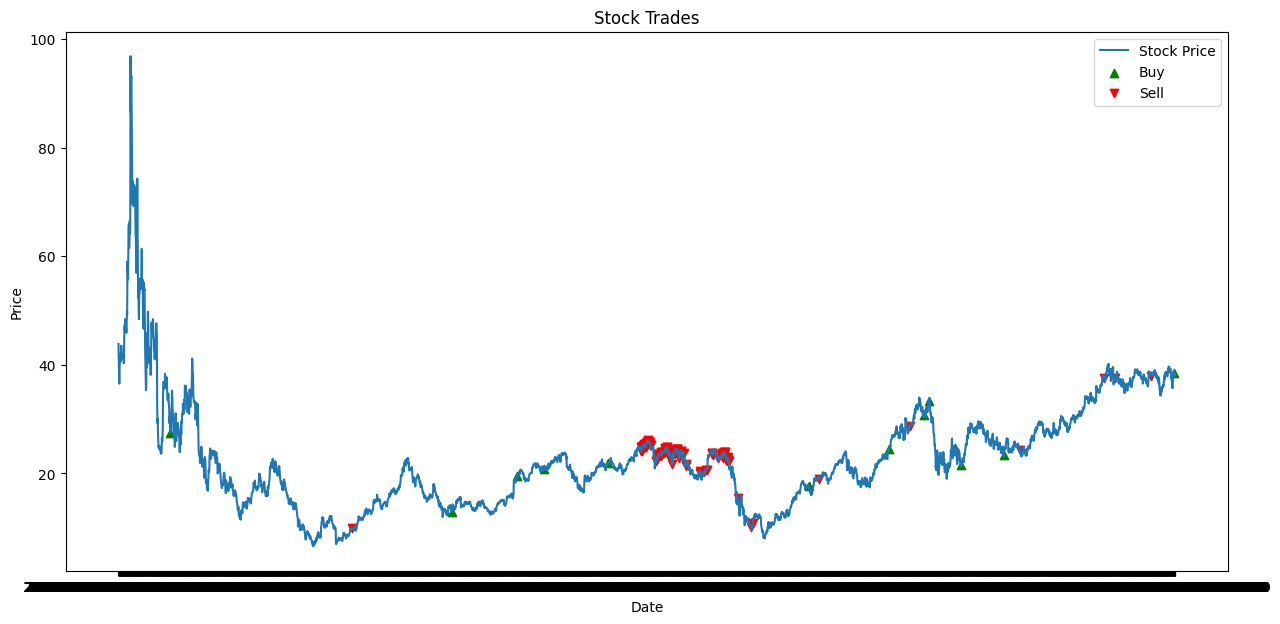

<Figure size 640x480 with 0 Axes>

In [62]:
#evaluation of the trained model on a specified date range
def evaluate(agent, env, start_date, end_date):
    df = env.df
    mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
    df = df.loc[mask]
    env.df = df.reset_index(drop=True)
    
    state, _ = env.reset()
    state = state.flatten()
    net_worths = []
    trades = []

    for current_step in range(len(env.df)):
        print(current_step)
        action = agent.act(state)
        next_state, reward, done, truncated, _ = env.step(action)
        next_state = next_state.flatten()
        trades.append((env.current_step, action[0], action[1]))  # Log the trade action
        state = next_state
        net_worths.append(env.net_worth)

    plt.figure(figsize=(15, 7))
    plt.plot(env.df['Date'], env.df['Close'], label='Stock Price')
    buy_trades = [trade for trade in trades if trade[1] == 0]
    sell_trades = [trade for trade in trades if trade[1] == 1]
    plt.scatter(env.df.loc[[trade[0] for trade in buy_trades], 'Date'], 
                env.df.loc[[trade[0] for trade in buy_trades], 'Close'], 
                marker='^', color='g', label='Buy', alpha=1)
    plt.scatter(env.df.loc[[trade[0] for trade in sell_trades], 'Date'], 
                env.df.loc[[trade[0] for trade in sell_trades], 'Close'], 
                marker='v', color='r', label='Sell', alpha=1)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Trades')
    plt.legend()
    plt.show()

    return net_worths


env = StockTradingEnv(df, render_mode='human')


agent.load("dqn_final20.pth")
evaluate(agent, env, start_date='2000-01-01', end_date='2015-01-01')
plt.savefig('eval.jpeg')
